## Genealogies distances - node distances var and tree distances
### Identifying sources of conflict from varying Ne and gen with simulations on 8 tip tree

Simulation setup:
1. Vary Gentimes -> g = 1 -> Tc
2. Vary Ne -> g = 1 or 10 -> same Tc
3. Variable Ne and gen -> same Tc

In [1]:
from platform import python_version
print(python_version())

3.10.10


In [2]:
# this notebook was run on an 80 core work station. Modify the nthreads & njobs settings accordingly
! nproc

80


In [3]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor

In [4]:
# make directory for saving figures
Path("./evol-figs2/").mkdir(exist_ok=True)

In [5]:
# get an ultrametric imbalanced tree
TREE = toytree.rtree.imbtree(8, treeheight=1e6)
EDGES = [3, 4, 10, 11]
# EDGES = [0, 1, 2, 6, 7, 8, 9, 13, 14]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000

### FUNCTIONS

In [6]:
def one_batch_sim(tree, nloci, nsites, nthreads, seed, infer):
    """Return two dataframes with genealogies and gene trees, respectively."""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    if (nsites == 1) or (not infer):
        raxdf = None
    else:
        raxdf = ipcoal.phylo.infer_raxml_ng_trees(
            model, nthreads=nthreads, nproc=1, nworkers=1, do_not_autoscale_threads=True)
    return model.df, raxdf

In [7]:
def batch_sims(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, infer: bool = True):    
    """Return dataframes from simulations and tree inferences distributed to run in parallel"""
    if nloci == 1:
        return one_batch_sim(tree, nloci, nsites, nthreads, None)

    # not perfect
    nloci_per = int(nloci / njobs)
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(njobs):
            rasyncs[i] = pool.submit(one_batch_sim, *(tree, nloci_per, nsites, nthreads, None, infer))
    gdata = []
    rdata = []
    for i in range(njobs):
        gdf, rdf = rasyncs[i].result()
        gdf.locus += i * nloci_per
        gdata.append(gdf)
        if rdf is not None:
            rdf.locus += i * nloci_per
            rdata.append(rdf)
    gdata = pd.concat(gdata, ignore_index=True)
    if rdata:
        rdata = pd.concat(rdata, ignore_index=True)
    return gdata, rdata

In [8]:
def one_concat(tree, nloci, nsites, nthreads, seed: int = None, nworkers: int = None):
    """Infer a concatenation tree"""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    raxtree = ipcoal.phylo.infer_raxml_ng_tree(
            model, nthreads=nthreads, nworkers=nworkers, do_not_autoscale_threads=True)
    return raxtree

In [9]:
def batch_concat(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, nreps: int = 10):
    """Return a list of inferred concatenation trees"""
    if nloci == 1:
        return one_batch_sim(tree, nloci, nsites, nthreads, None)

    # not perfect
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(nreps):
            rasyncs[i] = pool.submit(one_concat, *(tree, nloci, nsites, nthreads, None))
    return [i.result() for i in rasyncs.values()]

In [10]:
def iter_first_genealogies(model_df: pd.DataFrame):
    for _, df in model_df.groupby("locus"):
        yield toytree.tree(df.iloc[0, 6])

In [11]:
def plot_matrix(
    dat: np.ndarray,
    domain_min: float = None,
    domain_max: float = None,
    cmap: str = "BlueRed",
    gap: float = 0,
    mask_diagonal: bool = False,
    color_bar: bool = False,
) -> "Canvas":
    """Return a matrix heatmap """
    
    # get min and max of the off-diagonal elements
    if mask_diagonal:
        dat = dat.copy()
        dat[np.diag_indices_from(dat)] = np.nanmean(dat)
        
    dmin = dat.min() if domain_min is None else domain_min
    dmax = dat.max() if domain_max is None else domain_max
    cmap = toyplot.color.brewer.map(cmap, domain_min=dmin, domain_max=dmax)
    
    # add 20 pixels to the right if legend
    if color_bar:
        color_bar = 20
    else:
        color_bar = 0
    
    # draw the matrix table
    canvas = toyplot.Canvas(300 + color_bar, 300)
    ax1 = canvas.table(
        rows=dat.shape[0], 
        columns=dat.shape[1],
        bounds=(50, 250, 50, 250),
    )
    
    # apply colors to cells but not diagonals
    for ridx in range(dat.shape[0]):
        for cidx in range(dat.shape[1]):
            col = cmap.color(dat[ridx, cidx])
            ax1.cells.cell[ridx, cidx].style = {'fill': col, 'stroke': 'none'}
            
            # overwrite if masking
            if (ridx == cidx) and mask_diagonal:
                ax1.cells.cell[ridx, cidx].style = {'fill': 'black', 'stroke': 'none'}
            
    # style spacing between grid cells            
    ax1.body.gaps.columns[...] = gap
    ax1.body.gaps.rows[...] = gap
    
    ax2 = canvas.cartesian(bounds=(50, 250, 50, 250), margin=0, padding=0)
    ax2.x.ticks.labels.show = False
    ax2.x.spine.style["stroke"] = "black"
    ax2.x.spine.style["stroke-width"] = 2
    ax2.y.ticks.labels.show = False
    ax2.y.spine.style["stroke"] = "black"
    ax2.y.spine.style["stroke-width"] = 2
    ax3 = ax2.share('x')
    ax3.y.ticks.labels.show = False
    ax3.y.spine.style["stroke"] = "black"
    ax3.y.spine.style["stroke-width"] = 2
    ax4 = ax2.share('y')
    ax4.x.ticks.labels.show = False
    ax4.x.spine.style["stroke"] = "black"
    ax4.x.spine.style["stroke-width"] = 2
    
    # add a colorbar to canvas
    if color_bar:
        numberline = canvas.numberline(270, 250, 270, 50)
        numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
        numberline.axis.ticks.locator = toyplot.locator.Extended(only_inside=True)
        numberline.axis.ticks.show = True
        numberline.axis.ticks.near = False
        numberline.axis.ticks.style["stroke-width"] = 2
        numberline.axis.spine.style["stroke-width"] = 2
        numberline.axis.ticks.labels.style["font-size"] = 14
    return canvas

# (A-B): Species tree setup

## Species tree w/ variable `Ne`

In [12]:
# set parameters on the species tree
tree_ne = TREE.copy()
tree_ne = tree_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES}, default=NE_DEFAULT)
tree_ne = tree_ne.set_node_data("gt", default=GT_DEFAULT)
tree_ne = tree_ne.set_node_data("tg", {i: i.dist / i.gt for i in tree_ne})
tree_ne = tree_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in tree_ne})
tree_ne = tree_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in tree_ne})
tree_ne = tree_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in tree_ne})
tree_ne = tree_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in tree_ne})
tree_ne = tree_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in tree_ne})

# convert edge lens to units of generations.
tree_ne = tree_ne.set_node_data("dist", {i: i.tg for i in tree_ne})

# show data
tree_ne.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,1.164153e-10,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02
1,1,r1,1.164153e-10,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02
2,2,r2,1.164153e-10,2.857143e+05,NaN,500000.0,1,0.002,0.285714,2.857143e+05,571.428571,0.000006,0.02
3,3,r3,0.000000e+00,4.285714e+05,NaN,10000000.0,1,0.040,0.021429,4.285714e+05,17142.857143,0.000171,0.40
4,4,r4,0.000000e+00,5.714286e+05,NaN,10000000.0,1,0.040,0.028571,5.714286e+05,22857.142857,0.000229,0.40
5,5,r5,1.164153e-10,7.142857e+05,NaN,500000.0,1,0.002,0.714286,7.142857e+05,1428.571429,0.000014,0.02
6,6,r6,0.000000e+00,8.571429e+05,NaN,500000.0,1,0.002,0.857143,8.571429e+05,1714.285714,0.000017,0.02
7,7,r7,0.000000e+00,1.000000e+06,NaN,500000.0,1,0.002,1.000000,1.000000e+06,2000.000000,0.000020,0.02
8,8,,1.428571e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02
9,9,,2.857143e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,0.000003,0.02


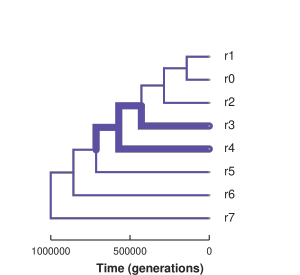

In [14]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt",
)
c, a, m = tree_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./evol-figs2/tree-imb-ne-gunits.svg")
c

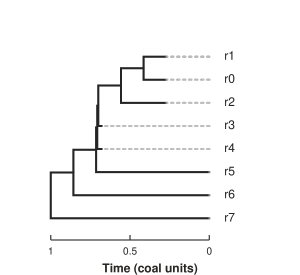

In [17]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True)
c, a, m = tree_ne.set_node_data("dist", {i: i.tc for i in tree_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./evol-figs2/tree-imb-ne-cunits.svg")
c

## Species tree w/ variable `gt`

In [18]:
tree_gt = TREE.copy()
tree_gt = tree_gt.set_node_data("Ne", default=NE_DEFAULT)
tree_gt = tree_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES}, default=GT_DEFAULT)
tree_gt = tree_gt.set_node_data("tg", {i: i.dist / i.gt for i in tree_gt})
tree_gt = tree_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in tree_gt})
tree_gt = tree_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in tree_gt})
tree_gt = tree_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in tree_gt})
tree_gt = tree_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in tree_gt})
tree_gt = tree_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in tree_gt})

# convert dist to units of generations. Draw and show data
tree_gt = tree_gt.set_node_data("dist", {i: i.tg for i in tree_gt})
tree_gt.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,2.714286e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02
1,1,r1,2.714286e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02
2,2,r2,2.714286e+05,2.857143e+05,NaN,500000.0,1,0.002,0.285714,2.857143e+05,571.428571,5.714286e-06,0.02
3,3,r3,6.785714e+05,2.142857e+04,NaN,500000.0,20,0.002,0.021429,2.142857e+04,42.857143,4.285714e-07,0.02
4,4,r4,6.785714e+05,2.857143e+04,NaN,500000.0,20,0.002,0.028571,2.857143e+04,57.142857,5.714286e-07,0.02
5,5,r5,1.164153e-10,7.142857e+05,NaN,500000.0,1,0.002,0.714286,7.142857e+05,1428.571429,1.428571e-05,0.02
6,6,r6,0.000000e+00,8.571429e+05,NaN,500000.0,1,0.002,0.857143,8.571429e+05,1714.285714,1.714286e-05,0.02
7,7,r7,0.000000e+00,1.000000e+06,NaN,500000.0,1,0.002,1.000000,1.000000e+06,2000.000000,2.000000e-05,0.02
8,8,,4.142857e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02
9,9,,5.571429e+05,1.428571e+05,NaN,500000.0,1,0.002,0.142857,1.428571e+05,285.714286,2.857143e-06,0.02


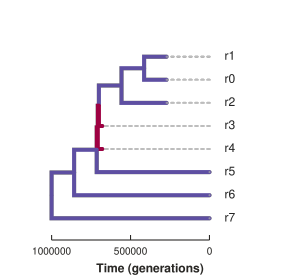

In [19]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
)
c, a, m = tree_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./evol-figs2/tree-imb-gt-gunits.svg")
c

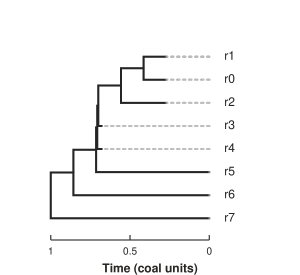

In [20]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True)
c, a, m = tree_gt.set_node_data("dist", {i: i.tc for i in tree_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./evol-figs2/tree-imb-gt-cunits.svg")
c

## Test batch functions

In [200]:
# test: get dataframes of true and inferred trees
gdf, rdf = batch_sims(tree_gt, nloci=100, nsites=1000, njobs=20, nthreads=3)
print(gdf.head())
print(rdf.head())

   locus  start   end  nbps  nsnps  tidx                    genealogy
0      0      0   412   412     34     0  ((r6:1223642.63771380577...
1      0    412   978   566     42     1  ((r7:1347647.54876739485...
2      0    978  1000    22      2     2  (r7:2399996.778123475611...
3      1      0   288   288     19     0  ((r2:880321.060071797692...
4      1    288   323    35      2     1  ((r6:1151749.63150036917...
   locus  start   end  nbps  nsnps                    gene_tree
0      0      0  1000  1000     78  (r7:0.015168,(r6:0.01625...
1      1      0  1000  1000     72  (r6:0.017192,(r4:0.00705...
2      2      0  1000  1000     80  ((r0:0.005076,(r2:0.0079...
3      3      0  1000  1000    102  (r4:0.002012,((((r1:0.00...
4      4      0  1000  1000     97  (((((r5:0.009685,r4:0.01...


In [201]:
# test: get raxml concat trees for (nloci * nsites) matrix
concats = batch_concat(tree_gt, nloci=100, nsites=1e4, njobs=10, nthreads=3, nreps=10)
toytree.mtree(concats).draw();

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="750.0px" height="250.0px" viewBox="0 0 750.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t613d09fc9c8441c8aa312a12155e62a6"> r7 r5 r0 r1 r2 r4 r3 r6 r4 r5 r2 r1 r0 r6 r7 r3 r1 r0 r7 r6 r5 r3 r4 r2 r7 r4 r3 r1 r0 r2 r5 r6

## Ensure species tree scenario is in anomaly zone

### Variable NE scenario

Astral inferred from true genealogies should get the tree CORRECT:

In [202]:
ugdf_ne, _ = batch_sims(tree_ne, nloci=NLOCI, nsites=1, njobs=20, nthreads=3, infer=False)

In [203]:
atree_true_ne = ipcoal.phylo.infer_astral_tree(ugdf_ne.genealogy).root("r7").ladderize()

In [204]:
c, a, m = atree_true_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-ne-true-astral.svg")
c

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t99109ae7de3c43c686e8db490a795085"> 1 1 0.57 0.5 1 nan r7 r6 r5 r4 r3 r2 r0 r1

RAxML inferred from concatenated sequences should get the tree WRONG:

In [206]:
concat_tree_ne = one_concat(tree_ne, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)

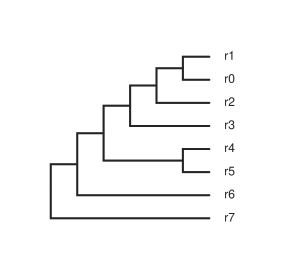

In [207]:
c, a, m = concat_tree_ne.root("r7").ladderize().draw(use_edge_lengths=False);
toyplot.svg.render(c, "./evol-figs2/infer-ne-1e7-concat.svg")
c

Astral inferred from empirical gene trees should get it increasingly wrong as locus lengths increase:

In [ ]:
# inferred raxml trees input to astral should probably get it right when nsites is small
_, rdf_ne_1e3 = batch_sims(tree_ne, nloci=NLOCI, nsites=1e3, njobs=20, nthreads=3, infer=True)

In [245]:
rdf_ne_1e3.to_csv("./rax-df-ne-1e3.csv")

In [248]:
atree_1e3_ne = ipcoal.phylo.infer_astral_tree(rdf_ne_1e3.gene_tree).root("r7").ladderize()

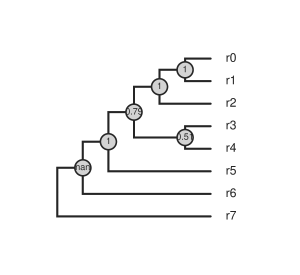

In [249]:
c, a, m = atree_1e3_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-ne-1e3-astral.svg")
c

In [ ]:
# inferred raxml trees input to astral should get it WRONG when nsites is very large
gdf_ne_1e5, rdf_ne_1e5 = batch_sims(tree_ne, nloci=NLOCI, nsites=1e5, njobs=20, nthreads=3, infer=True)

In [247]:
rdf_ne_1e5.to_csv("./rax-df-ne-1e5.csv")

In [219]:
atree_1e5_ne = ipcoal.phylo.infer_astral_tree(rdf_ne_1e5.gene_tree).root("r7").ladderize()

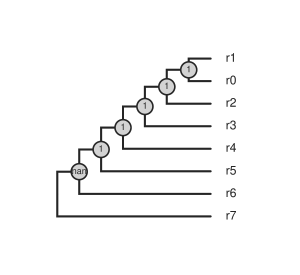

In [220]:
c, a, m = atree_1e5_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-ne-1e5-astral.svg")
c

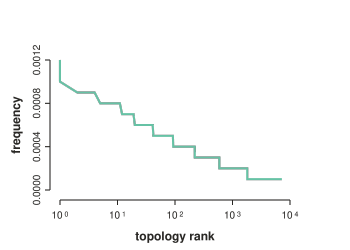

In [251]:
hist = [j for i, j in toytree.mtree(rdf_ne_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

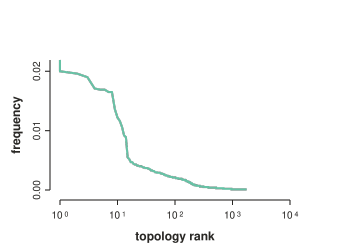

In [252]:
hist = [j for i, j in toytree.mtree(rdf_ne_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

### Variable GT scenario

Astral inferred from true genealogies should get the tree CORRECT:

In [221]:
ugdf_gt, _ = batch_sims(tree_gt, nloci=NLOCI, nsites=1, njobs=20, nthreads=3, infer=False)

In [222]:
atree_true_gt = ipcoal.phylo.infer_astral_tree(ugdf_gt.genealogy).root("r7").ladderize()

In [223]:
c, a, m = atree_true_gt.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-gt-true-astral.svg")
c

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td3cef2788cfa499ba23ae70e0509328a"> 1 1 0.83 0.48 1 nan r7 r6 r5 r4 r3 r2 r1 r0

RAxML inferred from concatenated sequences should get the tree WRONG:

In [225]:
concat_tree_gt = one_concat(tree_gt, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)

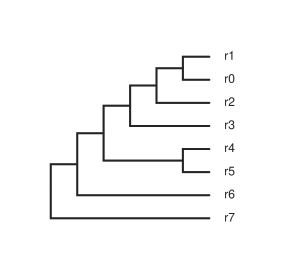

In [226]:
c, a, m = concat_tree_gt.root("r7").ladderize().draw(use_edge_lengths=False);
toyplot.svg.render(c, "./evol-figs2/infer-gt-1e7-concat.svg")
c

Astral inferred from empirical gene trees should get it increasingly wrong as locus lengths increase:

In [233]:
# inferred raxml trees input to astral should probably get it right when nsites is small
gdf_gt_1e3, rdf_gt_1e3 = batch_sims(tree_gt, nloci=NLOCI, nsites=1e3, njobs=20, nthreads=3, infer=True)

In [234]:
rdf_gt_1e3.to_csv("./rax-df-gt-1e3.csv")

In [235]:
atree_1e3_gt = ipcoal.phylo.infer_astral_tree(rdf_gt_1e3.gene_tree).root("r7").ladderize()

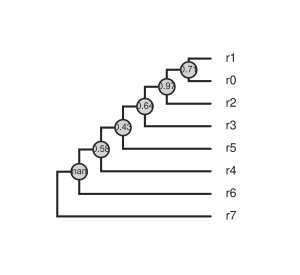

In [236]:
c, a, m = atree_1e3_gt.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-gt-1e3-astal.svg")
c

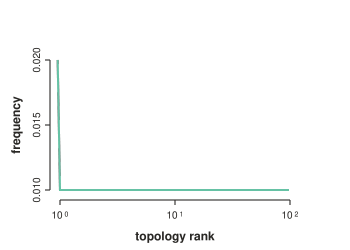

In [253]:
genealogies = list(iter_first_genealogies(gdf_gt_1e3))
hist = [j for i, j in toytree.mtree(genealogies).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

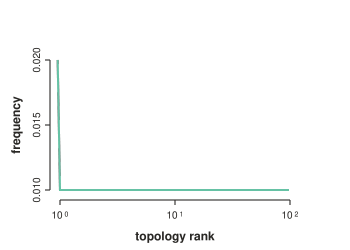

In [243]:
hist = [j for i, j in toytree.mtree(rdf_gt_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

Now with longer loci;

In [ ]:
# inferred raxml trees input to astral should get it WRONG when nsites is very large
_, rdf_gt_1e5 = batch_sims(tree_gt, nloci=NLOCI, nsites=1e5, njobs=20, nthreads=3, infer=True)

In [163]:
rdf_gt_1e5.to_csv("./rax-df-gt-1e5.csv")

In [164]:
atree_gt_1e5 = ipcoal.phylo.infer_astral_tree(rdf_gt_1e5.gene_tree).root("r7").ladderize()

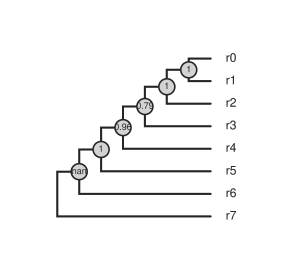

In [165]:
c, a, m = atree_gt_1e5.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-gt-1e5-astral.svg")
c

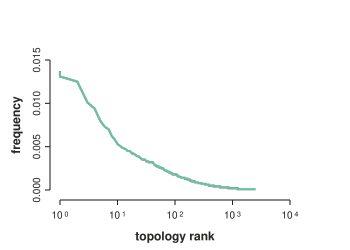

In [177]:
# hist = [j for i, j in toytree.mtree(rdf_gt_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

In [175]:
# toytree.mtree(rdf_gt_1e5.gene_tree)

# SUPERSETS

In [255]:
_, batch = batch_sims(tree_gt, nloci=50_000, nsites=1e5, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-gt-1e5.csv")

In [256]:
_, batch = batch_sims(tree_gt, nloci=50_000, nsites=1e3, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-gt-1e3.csv")

In [257]:
_, batch = batch_sims(tree_ne, nloci=50_000, nsites=1e5, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-ne-1e5.csv")

In [ ]:
_, batch = batch_sims(tree_ne, nloci=50_000, nsites=1e3, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-ne-1e3.csv")

In [ ]:
trees = []
for i in range(100):
    concat_tree_gt = one_concat(tree_gt, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)
    trees.append(concat_tree_gt)
toytree.mtree(trees).write("./superset-concat-gt.nwk")

In [ ]:
trees = []
for i in range(100):
    concat_tree_ne = one_concat(tree_ne, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)
    trees.append(concat_tree_ne)
toytree.mtree(trees).write("./superset-concat-ne.nwk")

## SNAQ network inference
Reuse the tree distributions from the last section to run network inferences.

In [176]:
J = "/home/deren/local/julia-1.8.1/bin/julia"
ipcoal.phylo.infer_snaq_network(
    rdf_gt_1e5.gene_tree, name="rax-gt-1e5", binary_path=J, starting_tree=tree_gt)


In [178]:
toytree.network.parse_network_to_tree_and_admix(
    "/tmp/analysis-snaq/rax-gt-1e5-snaq-p1907859.snaq.net-1.networks")

(<toytree.ToyTree at 0x7f55abdd7d30>, [(['r2'], ['r0'], 0.5, {}, '0.106')])

In [ ]:
ipcoal.phylo.infer_snaq_network(
    rdf_gt_1e5.gene_tree, name="true-gt-1e5", binary_path=J, starting_tree=tree_gt)


In [183]:
ipcoal.phylo.infer_snaq_network(
    list(iter_first_genealogies(gdf_gt_1e5)), 
    name="sim-gt-1e5", binary_path=J, starting_tree=tree_gt)

In [185]:
toytree.network.parse_network_to_tree_and_admix(
    "/tmp/analysis-snaq/sim-gt-1e5-snaq-p1907859.snaq.net-1.networks")

(<toytree.ToyTree at 0x7f55ab1a7850>, [(['r1'], ['r4'], 0.5, {}, '0.0627')])

## MS-SMC calculation

In [254]:
# calculate expected distance until a topology turnover given the species tree
model = ipcoal.Model(tree=tree_ne)
model.sim_trees(1000)

# get expected distance for 1000 tres
edist = pd.Series([ipcoal.smc.get_expected_waiting_distance_to_topology_change(
    tree_ne, 
    toytree.tree(model.df.genealogy[i]),
    {i: [i] for i in tree_ne.get_tip_labels()},
    1e-9,
) for i in range(model.df.shape[0])])

# print stats
edist.describe()

count    1000.000000
mean      177.862451
std        26.088184
min        93.751485
25%       159.722729
50%       177.099689
75%       194.246807
max       276.742220
dtype: float64

In [18]:
# calculate the tree distance of astral true genealogy tree for 100 sets of 1000 genealogies
model = ipcoal.Model(tree=tree_ne)
model.sim_trees(nloci=5000, nsites=1)
atrees = [ipcoal.phylo.infer_astral_tree(model.df.sample(1000).genealogy) for i in range(10)]
pd.Series([i.distance.get_treedist_quartets(tree_ne).similarity_to_reference for i in atrees]).describe()

count    10.000000
mean      0.061429
std       0.064961
min       0.000000
25%       0.000000
50%       0.057143
75%       0.125000
max       0.128571
dtype: float64

# MATRIX FIGURES

## (C-E) Variance in node distances among genealogies

### Node distance DEMO

In [ ]:
from ipcoal.phylo.src.infer_raxml_ng import infer_raxml_ng_tree_from_phylip

In [146]:
table = toytree.distance.get_tip_distance_matrix(tree_ne, topology_only=True, df=True)
table

,r0,r1,r2,r3,r4,r5,r6,r7
r0,0,2,3,4,5,6,7,8
r1,2,0,3,4,5,6,7,8
r2,3,3,0,3,4,5,6,7
r3,4,4,3,0,3,4,5,6
r4,5,5,4,3,0,3,4,5
r5,6,6,5,4,3,0,3,4
r6,7,7,6,5,4,3,0,3
r7,8,8,7,6,5,4,3,0


## (C) Unlinked

In [16]:
variable_ne, _ = batch_sims(tree_ne, nloci=2 * NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)

### Unlinked variable Ne

In [17]:
mdata = variable_ne

# iterate over pairs of trees
distances = []
name_order = sorted(tree_ne.get_tip_labels())
for i in range(NLOCI):
    idx = 2 * i
    jdx = idx + 1
    tree1 = toytree.tree(mdata.genealogy[idx])
    tree2 = toytree.tree(mdata.genealogy[jdx])
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_unlinked_var = np.var(distances, axis=0)
# arr_variable_ne_unlinked_mean = np.mean(distances, axis=0)

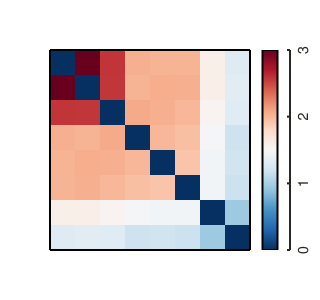

In [19]:
c = plot_matrix(arr_variable_ne_unlinked_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "evol-figs2/variable-ne-unlinked-var.svg")
c

### Unlinked variable gt

In [20]:
# variable_gt = ipcoal.Model(tree=tree_gt)
# variable_gt.sim_trees(nloci=2 * NLOCI, nsites=1) 

In [21]:
variable_gt, _ = batch_sims(tree_gt, nloci=2 * NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)

In [22]:
mdata = variable_gt

# iterate over pairs of trees
distances = []
name_order = sorted(tree_gt.get_tip_labels())
for i in range(NLOCI):
    idx = 2 * i
    jdx = idx + 1
    tree1 = toytree.tree(mdata.genealogy[idx])
    tree2 = toytree.tree(mdata.genealogy[jdx])
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)

arr_variable_gt_unlinked_var = np.var(distances, axis=0)
# arr_variable_gt_unlinked_mean = np.mean(distances, axis=0)

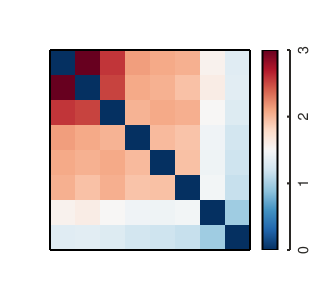

In [23]:
c = plot_matrix(arr_variable_gt_unlinked_var, color_bar=True, domain_max=3.);
toyplot.svg.render(c, "evol-figs2/variable-gt-unlinked-var.svg")
c

In [24]:
# plot_matrix(arr_variable_gt_unlinked_mean, color_bar=True);

# (D) Linked

### Vary Ne 2000

In [25]:
# vary_Ne_linked_2000 = ipcoal.Model(tree=tree_ne)
# vary_Ne_linked_2000.sim_trees(nloci=NLOCI, nsites=2000) 

In [26]:
variable_ne_2K_true, _ = batch_sims(tree_ne, nloci=10_000, nsites=2000, njobs=20, nthreads=3, infer=False)

In [27]:
mdata = variable_ne_2K_true

# iterate over pairs of trees
distances = []
name_order = sorted(tree_ne.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_linked_2K_var = np.var(distances, axis=0)
# arr_variable_ne_linked2000_mean = np.mean(distances, axis=0)

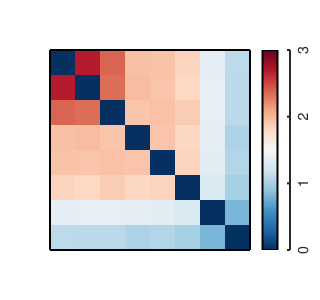

In [30]:
c = plot_matrix(arr_variable_ne_linked_2K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "evol-figs2/variable-ne-linked-2K-var.svg")
c

In [31]:
# plot_matrix(arr_variable_ne_linked2000_mean, color_bar=True, domain_max=None, domain_min=0);

### Vary Ne 10K

In [32]:
variable_ne_10K_true, _ = batch_sims(tree_ne, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=3, infer=False)

In [33]:
mdata = variable_ne_10K_true

# iterate over pairs of trees
distances = []
name_order = sorted(tree_ne.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_linked_10K_var = np.var(distances, axis=0)

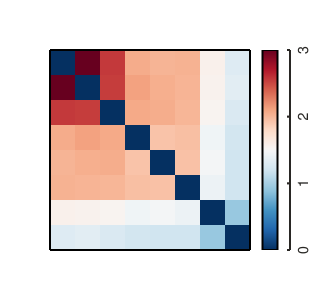

In [34]:
c = plot_matrix(arr_variable_ne_linked_10K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "evol-figs2/variable-ne-linked-10K-var.svg")
c

In [35]:
# plot_matrix(arr_variable_ne_linked10000_mean, color_bar=True, domain_max=None, domain_min=0);

## Vary gen

### Vary gt 2000

In [36]:
variable_gt_2K_true, _ = batch_sims(tree_gt, nloci=NLOCI, nsites=2_000, njobs=20, nthreads=3, infer=False)

In [37]:
mdata = variable_gt_2K_true

# iterate over pairs of trees
distances = []
name_order = sorted(tree_ne.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_gt_linked_2K_var = np.var(distances, axis=0)

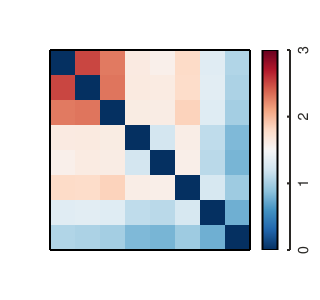

In [38]:
c = plot_matrix(arr_variable_gt_linked_2K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "evol-figs2/variable-gt-linked-2K-var.svg")
c

In [39]:
# plot_matrix(arr_variable_gt_linked2000_mean, color_bar=True, domain_max=None, domain_min=0);

### Vary gt 10K

In [40]:
variable_gt_10K_true, _ = batch_sims(tree_gt, nloci=NLOCI, nsites=10_000, njobs=20, nthreads=3, infer=False)

In [41]:
mdata = variable_gt_10K_true

# iterate over pairs of trees
distances = []
name_order = sorted(tree_ne.get_tip_labels())
for i, df in mdata.groupby("locus"):
    newick1 = df.iloc[0, 6]
    newick2 = df.iloc[-1, 6]
    tree1 = toytree.tree(newick1)
    tree2 = toytree.tree(newick2)
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_gt_linked_10K_var = np.var(distances, axis=0)

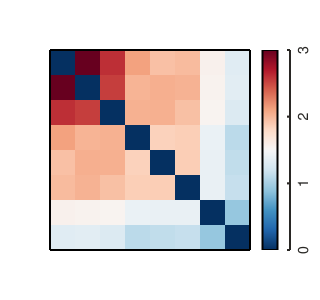

In [42]:
c = plot_matrix(arr_variable_gt_linked_10K_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "evol-figs2/variable-gt-linked-10K-var.svg")
c

In [43]:
# plot_matrix(arr_variable_gt_linked10000_mean, color_bar=True, domain_max=None, domain_min=0);

# (E) Node distance Difference
How much more similar are two linked genealogies at 10Kb compared to two random genealogies?

Taxa that exhibit less variance than two random trees are (r0, r1), (r6, r7), and these two clades with each other. In other words, these clades with long generation times (shorter species tree edges in numbers of generations) are broken up by recombination less often across the span of a locus. 

In particular, LESS OFTEN THAN IN THE COMPARISON BELOW with variable Ne.


### VARIANCE DIFFERENCE

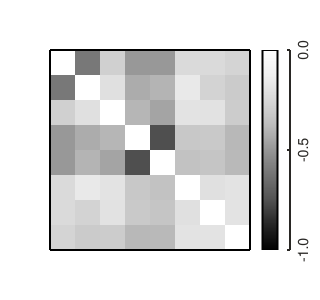

In [44]:
diff = (arr_variable_gt_linked_2K_var - arr_variable_gt_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, cmap="Greys");
toyplot.svg.render(c, "evol-figs2/variable-gt-linked-2K-var-diff.svg")
c

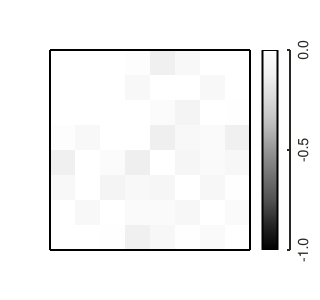

In [47]:
diff = (arr_variable_gt_linked_10K_var - arr_variable_gt_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, domain_max=0, cmap="Greys");
toyplot.svg.render(c, "evol-figs2/variable-gt-linked-10K-var-diff.svg")
c

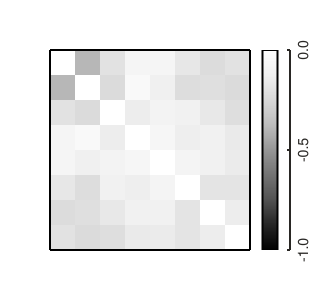

In [48]:
diff = (arr_variable_ne_linked_2K_var - arr_variable_ne_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, cmap="Greys");
toyplot.svg.render(c, "evol-figs2/variable-ne-linked-2K-var-diff.svg")
c

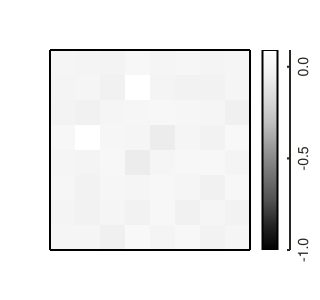

In [49]:
diff = (arr_variable_ne_linked_10K_var - arr_variable_ne_unlinked_var)
c = plot_matrix(diff, color_bar=True, domain_min=-1, cmap="Greys");
toyplot.svg.render(c, "evol-figs2/variable-ne-linked-10K-var-diff.svg")
c

### MEANS DIFFERENCE

In [68]:
# diff = (arr_variable_gt_linked10000_mean - arr_variable_gt_unlinked_mean)
# plot_matrix(diff, color_bar=True, domain_min=-0.5, domain_max=0);

In [69]:
# diff = (arr_variable_ne_linked10000_mean - arr_variable_ne_unlinked_mean)
# plot_matrix(diff, color_bar=True, domain_min=-0.5, domain_max=0);

# TREE INFERENCE

In [130]:
for i in range(2):
    # simulate data in batch
    variable_gt_2K_true, variable_gt_2K_rax = batch_sims(
        tree_gt, nloci=1_000, nsites=2_000, njobs=20, nthreads=3, infer=True)
    
    # save simulated data...
    # ...
    
    # infer astral true
    astral_true = ipcoal.phylo.infer_astral_tree(variable_gt_2K_true.genealogy)
    dist_true = astral_true.distance.get_treedist_rfg_mci(tree_gt, normalize=True)
    astral_true.draw()

    # infer astral empirical
    astral_rax = ipcoal.phylo.infer_astral_tree(variable_gt_2K_rax.gene_tree)
    dist_rax = astral_rax.distance.get_treedist_rfg_mci(tree_gt, normalize=True)
    astral_rax.draw()

    # infer snaq true
    # snaq_true = 
    
    print(dist_true, dist_rax)

0.0 0.1790338045715902
0.19443359141936595 0.19443359141936595


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t85dd32e254084b5f82f5a031b4c697ae"> r7 r6 r5 r4 r3 r2 r1 r0

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t1496629a1a4d494cb4cd65ed9b3231f2"> r4 r2 r0 r1 r3 r7 r6 r5

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t4dc84a41f103430bad3a4956202e69f6"> r6 r7 r5 r4 r2 r0 r1 r3

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf599a14164ae4677b99ff5843dd9ea27"> r6 r4 r5 r3 r2 r1 r0 r7

In [133]:
ipcoal.phylo.infer_snaq_network(variable_gt_2K_true.genealogy, binary_path="/home/deren/local/julia-1.8.1/bin/julia")

UnboundLocalError: local variable 'net_in' referenced before assignment

In [80]:
# simulate loci representing multiple genealogies each
vary_Ne_linked_10000_loci = ipcoal.Model(tree_ne)
vary_Ne_linked_10000_loci.sim_loci(nloci=NLOCI, nsites=10_000)

In [81]:
# infer and write the raxml trees df
raxtrees_vary_Ne_linked_10000 = ipcoal.phylo.infer_raxml_ng_trees(vary_Ne_linked_10000_loci, nthreads=4, nproc=4, nworkers=1)
raxtrees_vary_Ne_linked_10000.to_csv("./raxtrees_vary_Ne_linked_10000_imb")

In [82]:
astral_tree = ipcoal.phylo.infer_astral_tree(raxtrees_vary_Ne_linked_10000.gene_tree)
astral_tree.write("./astral_vary_Ne_linked_10000_imb")

In [83]:
astral_tree.draw(ts='s');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6df4bac81bf54793b5f001421ebcb96c"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r4 r3 r6 r7 r2 r0 r1 r5

In [ ]:
from ipcoal.phylo...

In [84]:
# simulate loci representing multiple genealogies each
vary_gt_linked_10000_loci = ipcoal.Model(tree_gt)
vary_gt_linked_10000_loci.sim_loci(nloci=NLOCI, nsites=10_000)

In [85]:
# infer and write the raxml trees df
raxtrees_vary_gt_linked_10000 = ipcoal.phylo.infer_raxml_ng_trees(vary_gt_linked_10000_loci, nthreads=4, nproc=4, nworkers=1)
raxtrees_vary_gt_linked_10000.to_csv("./raxtrees_vary_gt_linked_10000_imb")

In [86]:
astral_tree = ipcoal.phylo.infer_astral_tree(raxtrees_vary_gt_linked_10000.gene_tree)
astral_tree.write("./astral_vary_gt_linked_10000_imb")

In [87]:
astral_tree.draw('s');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="275.0px" viewBox="0 0 300.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6edca90b264246ac80d7a4c2d45b92c6"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r2 r3 r4 r5 r7 r6 r1

In [56]:
# simulate loci representing multiple genealogies each
vary_gt_linked_50000_loci = ipcoal.Model(tree_gt)
vary_gt_linked_50000_loci.sim_loci(nloci=NLOCI, nsites=50_000)

# infer and write the raxml trees df
raxtrees_vary_gt_linked_50000 = ipcoal.phylo.infer_raxml_ng_trees(vary_gt_linked_50000_loci, nthreads=4, nproc=4, nworkers=1)
raxtrees_vary_gt_linked_50000.to_csv("./raxtrees_vary_gt_linked_50000_imb")

# infer astral tree
astral_tree = ipcoal.phylo.infer_astral_tree(raxtrees_vary_gt_linked_50000.gene_tree)
astral_tree.write("./astral_vary_gt_linked_50000_imb")
astral_tree.draw();

KeyboardInterrupt: 

In [ ]:
# simulate loci representing multiple genealogies each
vary_gt_linked_100000_loci = ipcoal.Model(tree_gt)
vary_gt_linked_100000_loci.sim_loci(nloci=NLOCI, nsites=100_000)

# infer and write the raxml trees df
raxtrees_vary_gt_linked_100000 = ipcoal.phylo.infer_raxml_ng_trees(vary_gt_linked_100000_loci, nthreads=4, nproc=6, nworkers=1)
raxtrees_vary_gt_linked_100000.to_csv("./raxtrees_vary_gt_linked_100000_imb")

# infer astral tree
astral_tree = ipcoal.phylo.infer_astral_tree(raxtrees_vary_gt_linked_100000.gene_tree)
astral_tree.write("./astral_vary_gt_linked_100000_imb")
astral_tree.draw();

In [96]:
astral_tree.get_node_data()

,idx,name,height,dist,support
0,0,r2,0.687931,1.000000,NaN
1,1,r1,0.363576,1.000000,NaN
2,2,r0,0.363576,1.000000,NaN
3,3,r7,0.293079,1.000000,NaN
4,4,r6,0.293079,1.000000,NaN
5,5,r5,0.000000,1.000000,NaN
6,6,r4,0.000000,1.000000,NaN
7,7,r3,0.687931,1.000000,NaN
8,8,,1.363576,0.018666,0.90
9,9,,1.293079,0.025470,0.98


In [76]:
tree1.distance.get_treedist_quartets(tree2)

Q                              70.000000
S                              48.000000
D                              22.000000
U                               0.000000
R1                              0.000000
R2                              0.000000
N                              70.000000
do_not_conflict                 0.314286
explicitly_agree                0.314286
strict_joint_assertions         0.314286
semistrict_joint_assertions     0.314286
steel_and_penny                 0.314286
symmetric_difference            0.314286
symmetric_divergence            0.371429
similarity_to_reference         0.314286
marczewski_steinhaus            0.478261
dtype: float64

# 3. Tree distance

### Unlinked

### Vary Ne

In [ ]:
toytree.distance.

In [427]:
vary_Ne_tree_dist_df_out = pd.DataFrame(columns= ["vary_Ne_trees", "RF", "RFI", "RFG MCI", "RFG SPI", "QRT"])

for i in range(0, vary_Ne.df.shape[0]-1):
    tree1 = toytree.tree(vary_Ne.df["genealogy"][i])
    tree2 = toytree.tree(vary_Ne.df["genealogy"][i+1])
    rf = toytree.distance.get_treedist_rf(tree1, tree2, normalize=True)
    rfi = toytree.distance.get_treedist_rfi(tree1, tree2, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(tree1, tree2, normalize=True)
    rfg_spi = toytree.distance.get_treedist_rfg_spi(tree1, tree2, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(tree1, tree2, normalize=True)
    
    vary_Ne_tree_dist_df_out.loc[len(vary_Ne_tree_dist_df_out.index)] = [str(str(i) + "," + str(i+1)), rf, rfi, rfg_mci, rfg_spi, 1-qrt] 

vary_Ne_tree_dist_df_out.to_csv('./vary_Ne_tree_dist.csv')
vary_Ne_tree_dist_df_out

,vary_Ne_trees,RF,RFI,RFG MCI,RFG SPI,QRT
0,"0,1",1.0,1.000000,0.815504,0.886954,0.800000
1,"1,2",1.0,1.000000,0.868209,0.917116,0.814286
2,"2,3",1.0,1.000000,0.775203,0.848339,0.742857
3,"3,4",1.0,1.000000,0.807965,0.869650,0.771429
4,"4,5",1.0,1.000000,0.634691,0.685572,0.542857
...,...,...,...,...,...,...
994,"994,995",1.0,1.000000,0.848663,0.907990,0.771429
995,"995,996",0.8,0.832957,0.659635,0.715058,0.642857
996,"996,997",1.0,1.000000,0.698935,0.762514,0.628571
997,"997,998",1.0,1.000000,0.776149,0.831499,0.714286


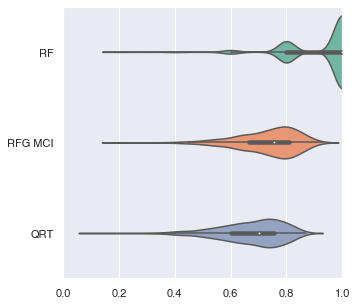

In [428]:
ax1 = sns.violinplot(data=vary_Ne_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax1.set_xlim(0, 1);

### Vary gen

In [424]:
vary_gen_tree_dist_df_out = pd.DataFrame(columns= ["vary_gen_trees", "RF", "RFG MCI", "QRT"])

for i in range(0, vary_gen.df.shape[0]-1):
    tree1 = toytree.tree(vary_gen.df["genealogy"][i])
    tree2 = toytree.tree(vary_gen.df["genealogy"][i+1])
    rf = toytree.distance.get_treedist_rf(tree1, tree2, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(tree1, tree2, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(tree1, tree2, normalize=True)
    
    vary_gen_tree_dist_df_out.loc[len(vary_gen_tree_dist_df_out.index)] = [str(str(i) + "," + str(i+1)), rf, rfg_mci, 1-qrt] 

vary_gen_tree_dist_df_out.to_csv('./vary_gen_tree_dist.csv')
vary_gen_tree_dist_df_out

,vary_gen_trees,RF,RFG MCI,QRT
0,"0,1",0.8,0.593789,0.571429
1,"1,2",1.0,0.826935,0.771429
2,"2,3",1.0,0.849068,0.757143
3,"3,4",0.8,0.538180,0.442857
4,"4,5",1.0,0.803722,0.700000
...,...,...,...,...
994,"994,995",1.0,0.662593,0.600000
995,"995,996",0.8,0.690071,0.671429
996,"996,997",1.0,0.775203,0.757143
997,"997,998",1.0,0.775203,0.785714


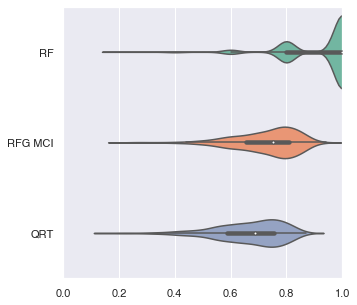

In [425]:
ax2 = sns.violinplot(data=vary_gen_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax2.set_xlim(0, 1);

### Vary Ne & gen

In [422]:
vary_Ne_gen_tree_dist_df_out = pd.DataFrame(columns= ["vary_Ne_gen_trees", "RF", "RFG MCI", "QRT"])

for i in range(0, vary_Ne_gen.df.shape[0]-1):
    tree1 = toytree.tree(vary_Ne_gen.df["genealogy"][i])
    tree2 = toytree.tree(vary_Ne_gen.df["genealogy"][i+1])
    rf = toytree.distance.get_treedist_rf(tree1, tree2, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(tree1, tree2, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(tree1, tree2, normalize=True)
    
    vary_Ne_gen_tree_dist_df_out.loc[len(vary_Ne_gen_tree_dist_df_out.index)] = [str(str(i) + "," + str(i+1)), rf, rfg_mci, 1-qrt] 

vary_Ne_gen_tree_dist_df_out.to_csv('./vary_Ne_gen_tree_dist.csv')
vary_Ne_gen_tree_dist_df_out

,vary_Ne_gen_trees,RF,RFG MCI,QRT
0,"0,1",0.8,0.587516,0.571429
1,"1,2",1.0,0.776149,0.685714
2,"2,3",1.0,0.867467,0.842857
3,"3,4",1.0,0.762942,0.728571
4,"4,5",1.0,0.746096,0.714286
...,...,...,...,...
994,"994,995",0.8,0.629140,0.585714
995,"995,996",1.0,0.836156,0.814286
996,"996,997",1.0,0.755256,0.714286
997,"997,998",1.0,0.734271,0.671429


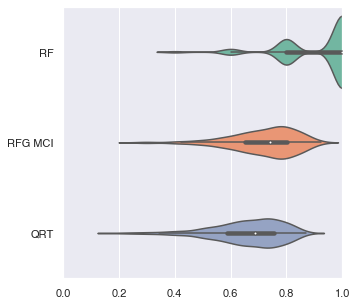

In [423]:
ax3 = sns.violinplot(data=vary_Ne_gen_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax3.set_xlim(0, 1);

### Linked

### Vary Ne 1000bp

In [420]:
vary_Ne_linked_1000_tree_dist_df_out = pd.DataFrame(columns= ["RF", "RFG MCI", "QRT"])

for key, val in vary_Ne_linked_1000.df.groupby("locus"):
    n0 = val.iloc[0, -1]
    n1 = val.iloc[-1, -1]
    t0 = toytree.tree(n0)
    t1 = toytree.tree(n1)
    rf = toytree.distance.get_treedist_rf(t0, t1, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(t0, t1, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(t0, t1, normalize=True)
    
    vary_Ne_linked_1000_tree_dist_df_out.loc[len(vary_Ne_linked_1000_tree_dist_df_out.index)] = [rf, rfg_mci, 1-qrt] 

vary_Ne_linked_1000_tree_dist_df_out

,RF,RFG MCI,QRT
0,1.0,0.738956,0.628571
1,0.8,0.640864,0.514286
2,1.0,0.849068,0.785714
3,1.0,0.834156,0.785714
4,0.8,0.546812,0.471429
...,...,...,...
95,1.0,0.865692,0.828571
96,1.0,0.750192,0.714286
97,0.8,0.618264,0.485714
98,1.0,0.761616,0.685714


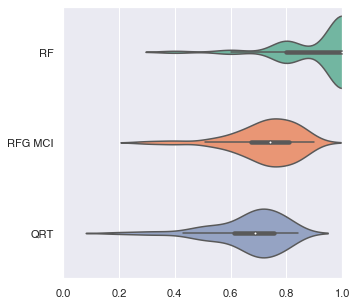

In [429]:
ax4 = sns.violinplot(data=vary_Ne_linked_1000_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax4.set_xlim(0, 1);

### Vary Ne 10000bp

In [430]:
vary_Ne_linked_10000_tree_dist_df_out = pd.DataFrame(columns= ["RF", "RFG MCI", "QRT"])

for key, val in vary_Ne_linked_10000.df.groupby("locus"):
    n0 = val.iloc[0, -1]
    n1 = val.iloc[-1, -1]
    t0 = toytree.tree(n0)
    t1 = toytree.tree(n1)
    rf = toytree.distance.get_treedist_rf(t0, t1, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(t0, t1, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(t0, t1, normalize=True)
    
    vary_Ne_linked_10000_tree_dist_df_out.loc[len(vary_Ne_linked_10000_tree_dist_df_out.index)] = [rf, rfg_mci, 1-qrt] 

vary_Ne_linked_10000_tree_dist_df_out

,RF,RFG MCI,QRT
0,0.4,0.283152,0.185714
1,0.8,0.539381,0.471429
2,1.0,0.780037,0.700000
3,0.8,0.549819,0.471429
4,1.0,0.800504,0.757143
...,...,...,...
95,1.0,0.790066,0.728571
96,1.0,0.836156,0.800000
97,1.0,0.711183,0.700000
98,1.0,0.849068,0.757143


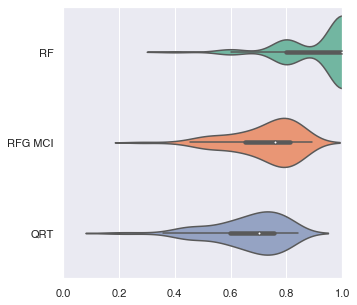

In [431]:
ax5 = sns.violinplot(data=vary_Ne_linked_10000_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax5.set_xlim(0, 1);

### Vary gen 1000bp

In [432]:
vary_gen_linked_1000_tree_dist_df_out = pd.DataFrame(columns= ["RF", "RFG MCI", "QRT"])

for key, val in vary_gen_linked_1000.df.groupby("locus"):
    n0 = val.iloc[0, -1]
    n1 = val.iloc[-1, -1]
    t0 = toytree.tree(n0)
    t1 = toytree.tree(n1)
    rf = toytree.distance.get_treedist_rf(t0, t1, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(t0, t1, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(t0, t1, normalize=True)
    
    vary_gen_linked_1000_tree_dist_df_out.loc[len(vary_gen_linked_1000_tree_dist_df_out.index)] = [rf, rfg_mci, 1-qrt] 

vary_gen_linked_1000_tree_dist_df_out

,RF,RFG MCI,QRT
0,1.0,0.835004,0.757143
1,1.0,0.688335,0.600000
2,1.0,0.752192,0.657143
3,1.0,0.778889,0.742857
4,1.0,0.780037,0.728571
...,...,...,...
95,1.0,0.711183,0.700000
96,1.0,0.706050,0.642857
97,1.0,0.801540,0.800000
98,1.0,0.778948,0.742857


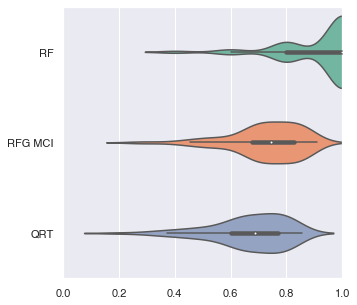

In [433]:
ax6 = sns.violinplot(data=vary_gen_linked_1000_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax6.set_xlim(0, 1);

### Vary gen 10000bp

In [434]:
vary_gen_linked_10000_tree_dist_df_out = pd.DataFrame(columns= ["RF", "RFG MCI", "QRT"])

for key, val in vary_gen_linked_10000.df.groupby("locus"):
    n0 = val.iloc[0, -1]
    n1 = val.iloc[-1, -1]
    t0 = toytree.tree(n0)
    t1 = toytree.tree(n1)
    rf = toytree.distance.get_treedist_rf(t0, t1, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(t0, t1, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(t0, t1, normalize=True)
    
    vary_gen_linked_10000_tree_dist_df_out.loc[len(vary_gen_linked_10000_tree_dist_df_out.index)] = [rf, rfg_mci, 1-qrt] 

vary_gen_linked_10000_tree_dist_df_out

,RF,RFG MCI,QRT
0,1.0,0.754414,0.657143
1,1.0,0.814541,0.757143
2,1.0,0.783567,0.742857
3,0.8,0.637246,0.585714
4,1.0,0.757273,0.714286
...,...,...,...
95,1.0,0.762942,0.657143
96,1.0,0.683579,0.614286
97,0.6,0.423128,0.357143
98,1.0,0.762942,0.728571


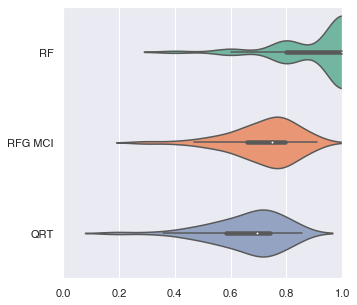

In [436]:
ax7 = sns.violinplot(data=vary_gen_linked_10000_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2", xmin=0, xmax=1);
ax7.set_xlim(0, 1);

### Vary Ne & gen 1000bp

In [437]:
vary_Ne_gen_linked_1000_tree_dist_df_out = pd.DataFrame(columns= ["RF", "RFG MCI", "QRT"])

for key, val in vary_Ne_gen_linked_1000.df.groupby("locus"):
    n0 = val.iloc[0, -1]
    n1 = val.iloc[-1, -1]
    t0 = toytree.tree(n0)
    t1 = toytree.tree(n1)
    rf = toytree.distance.get_treedist_rf(t0, t1, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(t0, t1, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(t0, t1, normalize=True)
    
    vary_Ne_gen_linked_1000_tree_dist_df_out.loc[len(vary_Ne_gen_linked_1000_tree_dist_df_out.index)] = [rf, rfg_mci, 1-qrt] 

vary_Ne_gen_linked_1000_tree_dist_df_out

,RF,RFG MCI,QRT
0,1.0,0.671455,0.557143
1,1.0,0.764852,0.728571
2,1.0,0.710472,0.585714
3,1.0,0.867467,0.842857
4,0.8,0.594972,0.528571
...,...,...,...
95,0.8,0.630049,0.542857
96,0.8,0.587516,0.571429
97,1.0,0.803263,0.728571
98,0.6,0.435196,0.414286


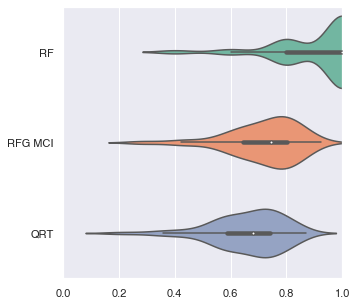

In [438]:
ax8 = sns.violinplot(data=vary_Ne_gen_linked_1000_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax8.set_xlim(0, 1);

### Vary Ne & gen 10000bp

In [439]:
vary_Ne_gen_linked_10000_tree_dist_df_out = pd.DataFrame(columns= ["RF", "RFG MCI", "QRT"])

for key, val in vary_Ne_gen_linked_10000.df.groupby("locus"):
    n0 = val.iloc[0, -1]
    n1 = val.iloc[-1, -1]
    t0 = toytree.tree(n0)
    t1 = toytree.tree(n1)
    rf = toytree.distance.get_treedist_rf(t0, t1, normalize=True)
    rfg_mci = toytree.distance.get_treedist_rfg_mci(t0, t1, normalize=True)
    qrt = toytree.distance.get_treedist_qrt(t0, t1, normalize=True)
    
    vary_Ne_gen_linked_10000_tree_dist_df_out.loc[len(vary_Ne_gen_linked_10000_tree_dist_df_out.index)] = [rf, rfg_mci, 1-qrt] 

vary_Ne_gen_linked_10000_tree_dist_df_out

,RF,RFG MCI,QRT
0,1.0,0.803263,0.728571
1,1.0,0.850971,0.800000
2,0.8,0.570892,0.442857
3,1.0,0.535425,0.500000
4,1.0,0.700006,0.657143
...,...,...,...
95,0.8,0.605241,0.571429
96,1.0,0.862090,0.814286
97,0.8,0.503461,0.371429
98,1.0,0.720222,0.685714


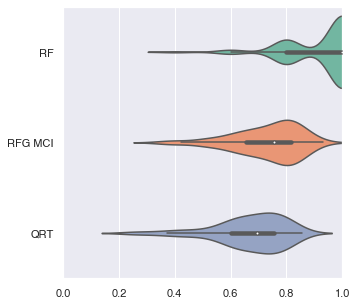

In [440]:
ax9 = sns.violinplot(data=vary_Ne_gen_linked_10000_tree_dist_df_out[["RF", "RFG MCI", "QRT"]], orient="h", palette="Set2");
ax9.set_xlim(0, 1);